In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)

/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

In [4]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [5]:
idx = np.random.permutation(len(labels))
X_data, labels = X_data[idx], labels[idx]

In [6]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=1e-3, test_size=1e-3, random_state = 5)

In [7]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [8]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [9]:
X_good.shape, X_train.shape, X_data.shape

((5102, 28), (11000, 28), (11000000, 28))

In [13]:
gm = GaussianMixture(n_components=15, n_init=6, covariance_type="full", verbose=0)

In [14]:
gm.fit(X_good)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [15]:
gm.bic(X_good)

242179.392989614

In [16]:
from scipy.stats import multivariate_normal

In [17]:
n_samples = X_good.shape[0]

In [18]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [19]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [20]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [21]:
gen.shape

(5093, 28)

In [22]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-2)

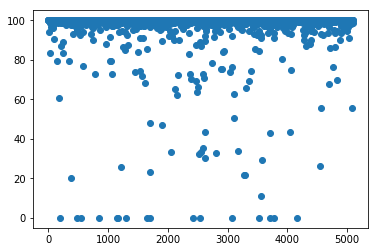

In [23]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [24]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [25]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [26]:
gen_w_normed.sum(), np.sum(weights)

(5102.0, 5102.0)

In [27]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [28]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [29]:
weights_mix.shape

(10195,)

In [30]:
# import tensorflow as tf
# s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [31]:
def build_net():
    net = Sequential()
    net.add(L.Dense(80, input_shape=(X_good.shape[1],), activation = 'relu'))
    #net.add(L.BatchNormalization())
    #net.add(L.Dense(32, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(1, activation='sigmoid'))

    adam = keras.optimizers.Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

In [32]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [33]:
ours_roc_aucs = {}
ours_pr_aucs = {}

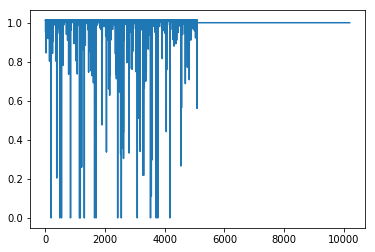

In [34]:
plt.plot(weights_mix)
plt.show()

Train on 9175 samples, validate on 1020 samples
Epoch 1/130
9175/9175 [==============================] - 6s 671us/step - loss: 0.9694 - val_loss: 0.9316
Epoch 2/130
9175/9175 [==============================] - 0s 2us/step - loss: 0.9533 - val_loss: 0.9148
Epoch 3/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.9327 - val_loss: 0.8983
Epoch 4/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.9282 - val_loss: 0.8827
Epoch 5/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.9159 - val_loss: 0.8681
Epoch 6/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.9051 - val_loss: 0.8547
Epoch 7/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.8869 - val_loss: 0.8424
Epoch 8/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.8713 - val_loss: 0.8312
Epoch 9/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.8652 - val_loss: 0.8212
Epoch 10/130
9175/9175 

Epoch 80/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7209 - val_loss: 0.7198
Epoch 81/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7197 - val_loss: 0.7196
Epoch 82/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7179 - val_loss: 0.7194
Epoch 83/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7177 - val_loss: 0.7192
Epoch 84/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7181 - val_loss: 0.7190
Epoch 85/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7147 - val_loss: 0.7189
Epoch 86/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7173 - val_loss: 0.7187
Epoch 87/130
9175/9175 [==============================] - 0s 2us/step - loss: 0.7170 - val_loss: 0.7185
Epoch 88/130
9175/9175 [==============================] - 0s 1us/step - loss: 0.7158 - val_loss: 0.7184
Epoch 89/130
9175/9175 [==============================] - 0s 1us

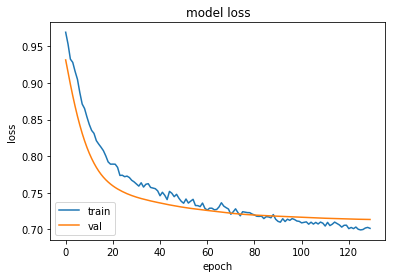

In [35]:
idx = np.random.permutation(len(y_mix))

net = build_net()
history = net.fit(X_mix[idx], y_mix[idx], 
                  batch_size=10000, epochs=130, validation_split = 0.1, verbose=1, shuffle=True, 
                  sample_weight=weights_mix[idx])
history_plot(history)

11000/11000 [==============================] - 0s 29us/step

('f1_score ', 0.5161118980169972)
confusion_matrix 
[[2619 2551]
 [2915 2915]]


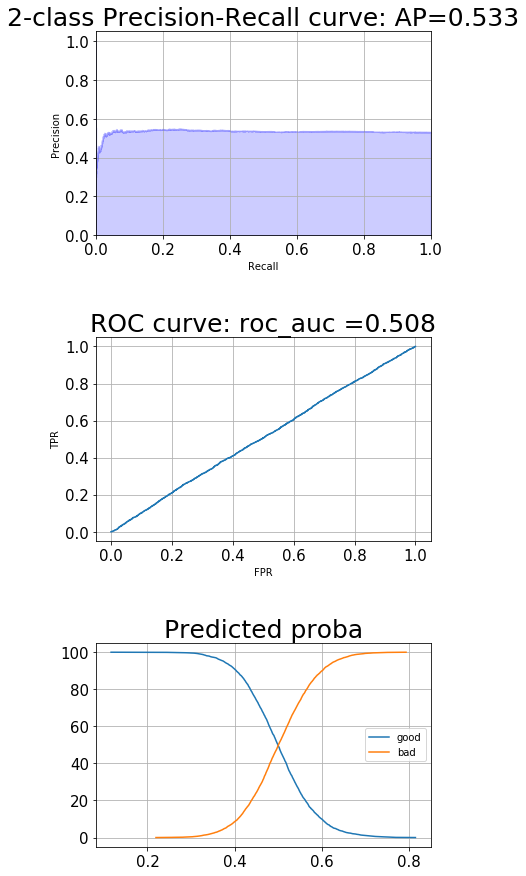

In [36]:
y_pred = net.predict(X_test, verbose=1)
ours_pr_aucs['ours with alpha=0.'] = [average_precision_score(y_test, y_pred)]
ours_roc_aucs['ours with alpha=0.'] = [roc_auc_score(y_test, y_pred)]

print ('')
perfomance(y_test, y_pred)

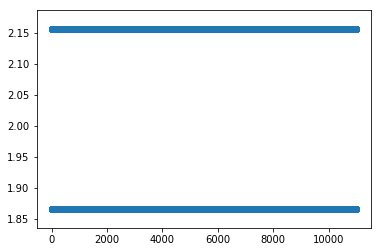

In [37]:
weights_train = np.array(len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train)))
plt.scatter(np.arange(len(y_train)),weights_train.ravel())
plt.show()

In [38]:
import math
n_splits=10
step = math.ceil((X_bad.shape[0]/(n_splits)))

 40%|████      | 4/10 [01:08<01:42, 17.08s/it]

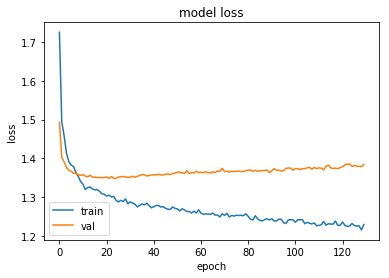

100%|██████████| 10/10 [03:34<00:00, 21.42s/it]


In [39]:
from tqdm import tqdm
alpha=1
for i in tqdm(range(1,n_splits+1)):
    if step*i>X_bad.shape[0]:
        end_ind=X_bad.shape[0]
    else:   
        end_ind=int(step*i)

    cur_X = np.concatenate((X_good, X_bad[:end_ind]))
    cur_y = np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()
    cur_w = np.concatenate((np.min(weights_train)*np.ones((X_good.shape[0],1)), np.max(weights_train)*np.ones((end_ind,1)))).ravel()
    
    idx = np.random.permutation(len(cur_y))
    cur_X, cur_y, cur_w = cur_X[idx], cur_y[idx], cur_w[idx]

    net = build_net()
    history = net.fit(cur_X, cur_y, 
                      batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                      sample_weight=cur_w)
    if i==5:
        history_plot(history)

    y_pred=net.predict(X_test)
    if alpha in ours_pr_aucs:
        # append the new number to the existing array at this slot
        ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
        ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
    else:
        # create a new array in this slot
        ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
        ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]

In [40]:
ours_pr_aucs, ours_roc_aucs

({1: [0.5323086834557544,
   0.5369120581937425,
   0.5318949680439958,
   0.5390646134281669,
   0.535769749152726,
   0.5308907676896087,
   0.5369774836213786,
   0.5331827341576171,
   0.5351172037521815,
   0.5311522173380704],
  'ours with alpha=0.': [0.5332657450955608]},
 {1: [0.5030345773710979,
   0.5045206545215669,
   0.5020589494079513,
   0.508642169662023,
   0.5033709784977987,
   0.5022896145130735,
   0.5068502642571107,
   0.5014551227393824,
   0.507241242025009,
   0.4977935443630126],
  'ours with alpha=0.': [0.5081889181217673]})

In [41]:
# net = build_net()
# history = net.fit(X_train, y_train, 
#                   batch_size=256, epochs=120, validation_split = 0.1, verbose=2, shuffle=True, 
#                   sample_weight=np.array(len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train))).ravel()
#                   )
# history_plot(history)

# y_pred = net.predict(X_test, verbose=1)
# ours_pr_aucs[1.] = [average_precision_score(y_test, y_pred)]
# ours_roc_aucs[1.] = [roc_auc_score(y_test, y_pred)]

# print ('')
# perfomance(y_test, y_pred)

In [42]:
points_cnt = 10
alphas = np.exp([np.log(0.05) * (points_cnt - i) * 1/points_cnt for i in range(points_cnt)]) # log scale
# alphas = [0.05, 0.1, 0.3, 0.5, 0.9]

In [43]:
def upd_weights(alpha, y_mix, num_true_bad, w_g = gen_w_normed):
    # sum of weights for good and bad data: beta * bad + (1 - beta) * good
    # proportionf of weights between real and fake data id alpha: alpha * true + (1 - alpha) * fake
    num_good = len(y_mix)-np.sum(y_mix)
    num_fake_bad = np.sum(y_mix)
    sum_w = num_good+num_fake_bad+num_true_bad
    
    beta = 0.5
    w_good = (1-beta)/num_good * np.ones((int(num_good),1))
    
    w_fake_bad = (1-alpha)*beta/num_fake_bad * w_g
    w_fake_bad = w_fake_bad.reshape(-1,1)
    
    if num_true_bad!=0:
        w_true_bad = alpha*beta/num_true_bad *np.ones((int(num_true_bad),1))
    else:
        w_true_bad=np.empty((0,1))
                           
    return sum_w*np.vstack((w_fake_bad, w_good, w_true_bad))

0.05000000000000001


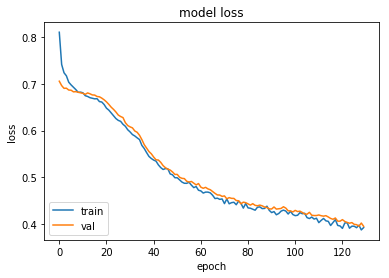

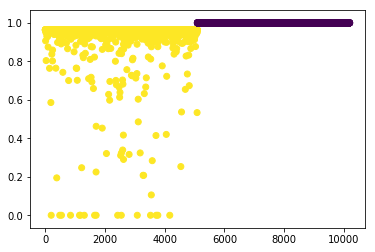

0.05000000000000001


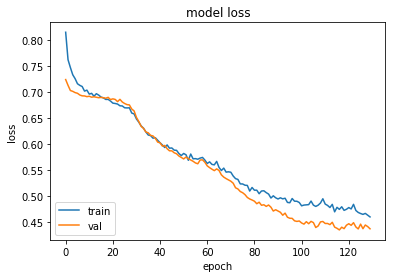

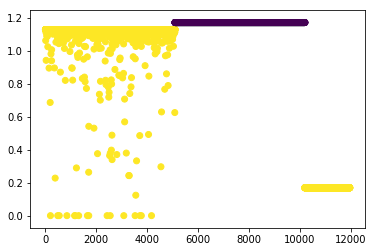

0.05000000000000001


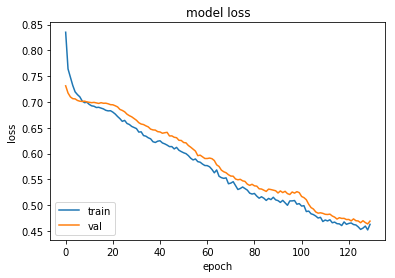

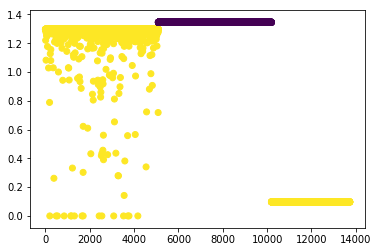

0.05000000000000001


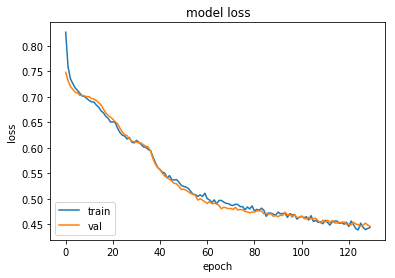

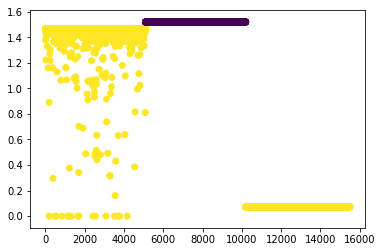

0.05807931748207712


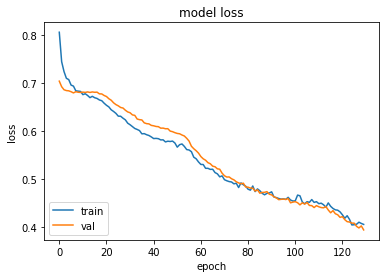

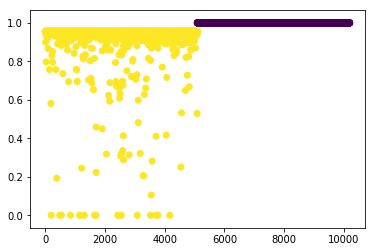

0.05807931748207712


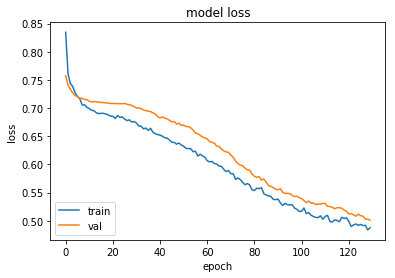

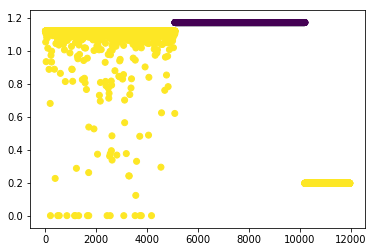

0.05807931748207712


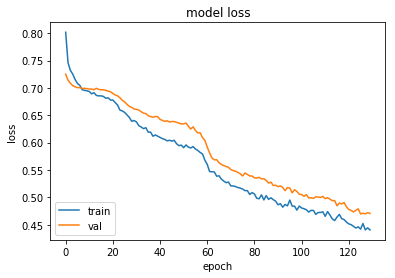

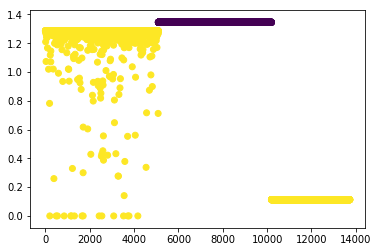

0.05807931748207712


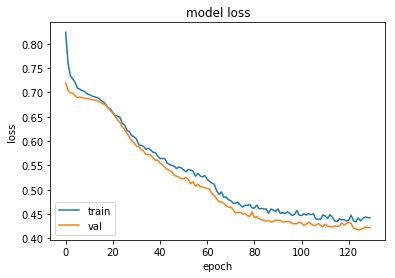

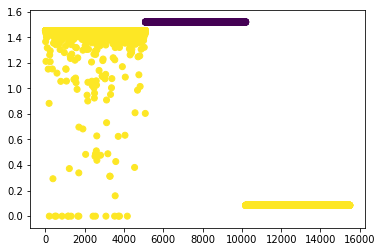

0.06746414238367818


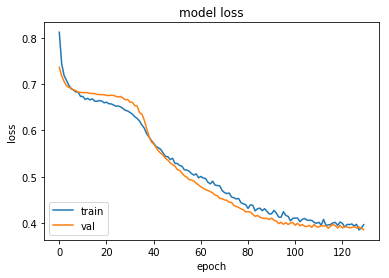

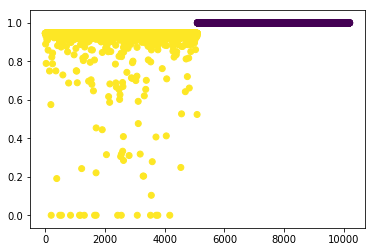

0.06746414238367818


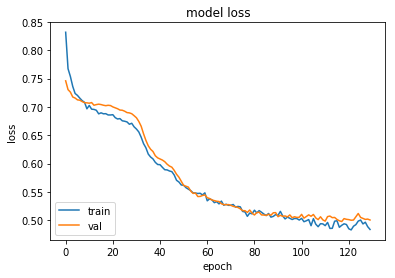

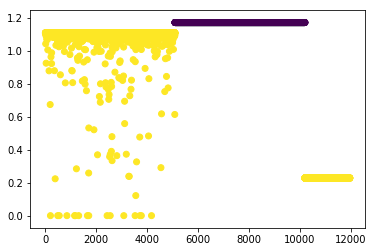

0.06746414238367818


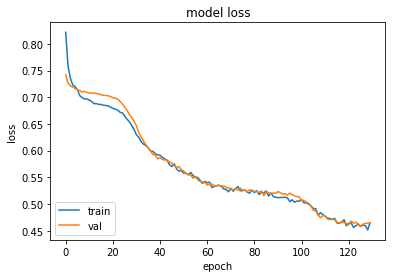

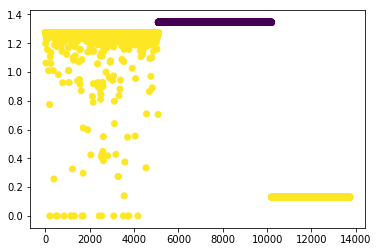

0.06746414238367818


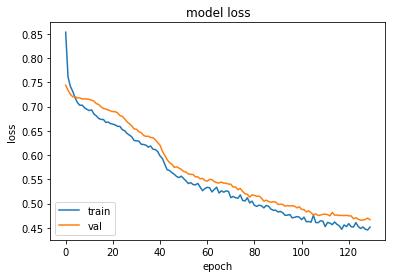

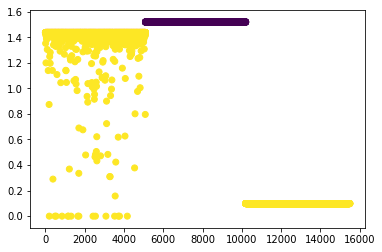

0.07836542688315398


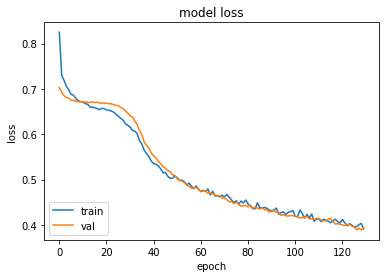

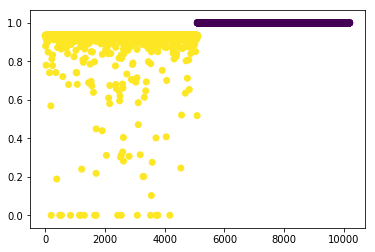

0.07836542688315398


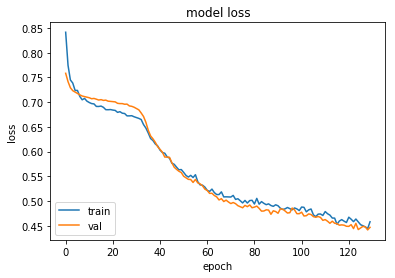

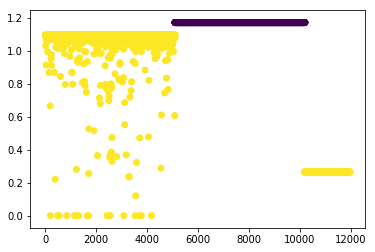

0.07836542688315398


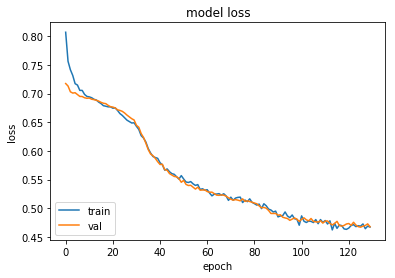

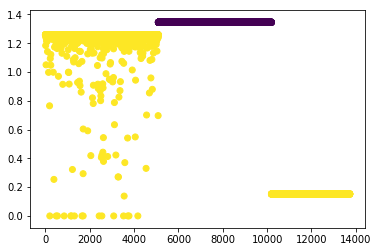

0.07836542688315398


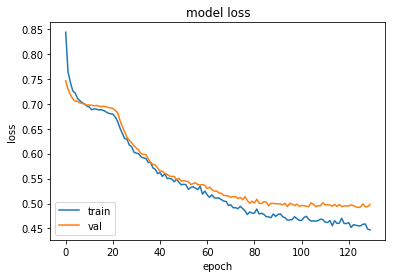

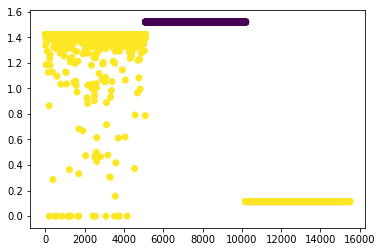

0.09102821015130401


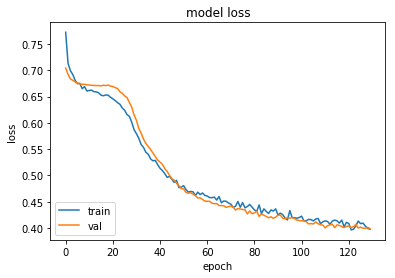

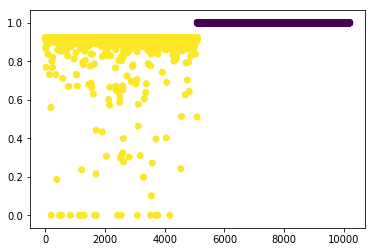

0.09102821015130401


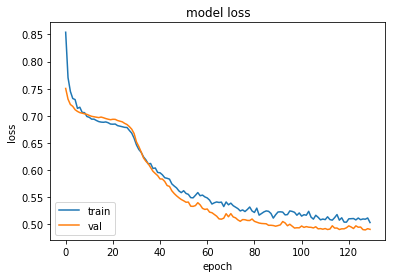

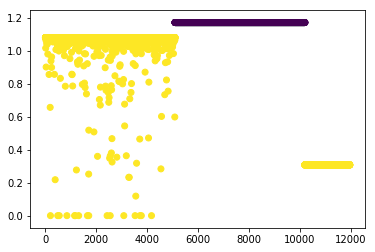

0.09102821015130401


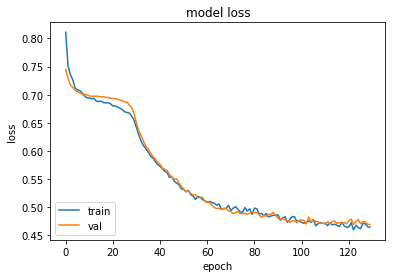

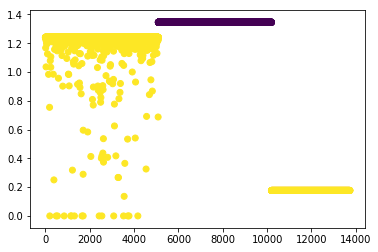

0.09102821015130401


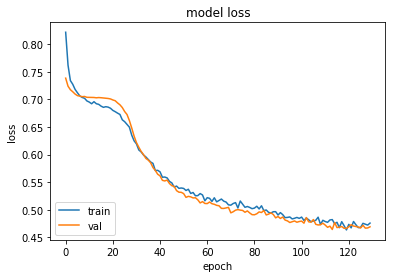

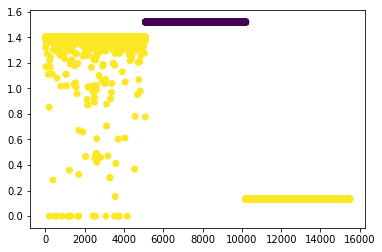

0.10573712634405641


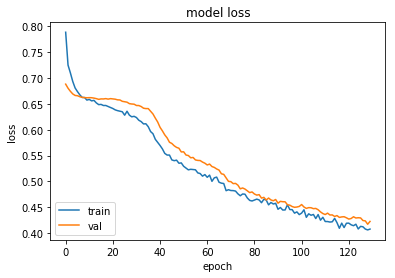

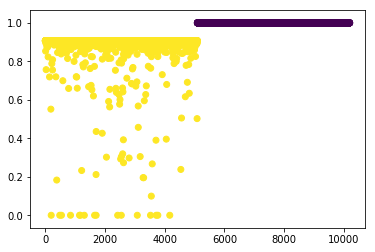

0.10573712634405641


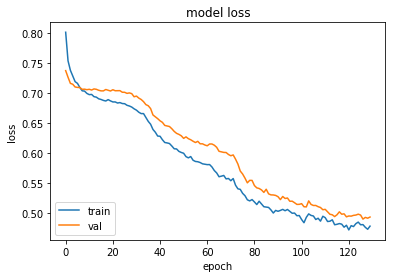

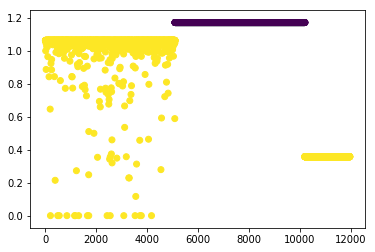

0.10573712634405641


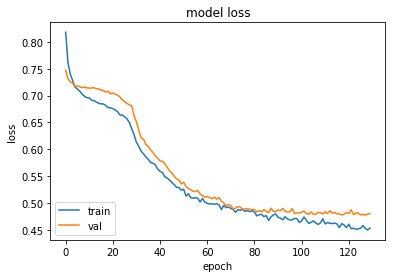

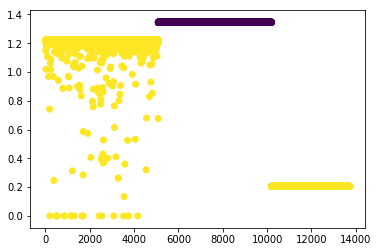

0.10573712634405641


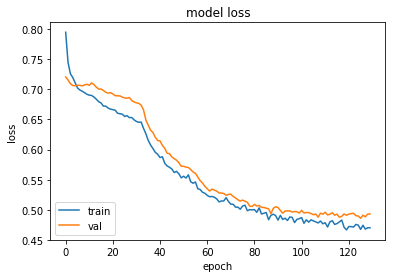

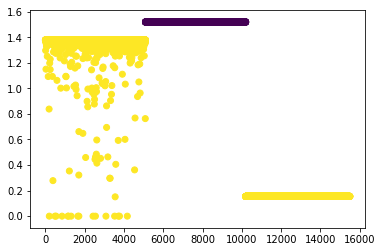

0.12282280261157903


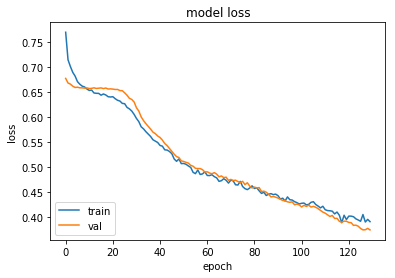

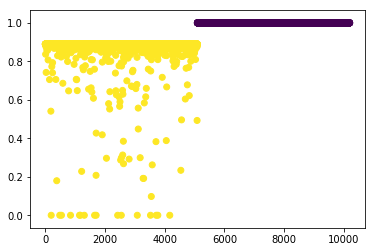

0.12282280261157903


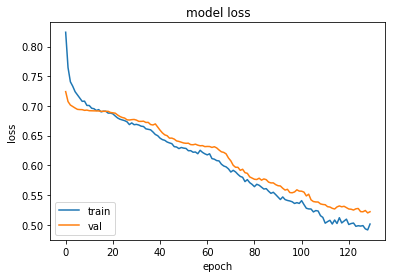

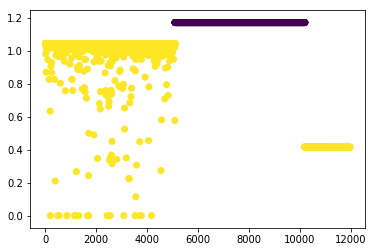

0.12282280261157903


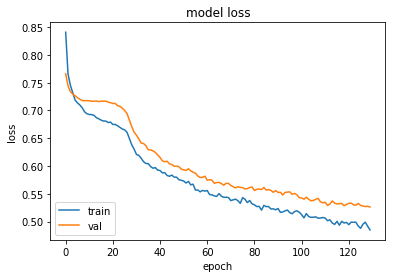

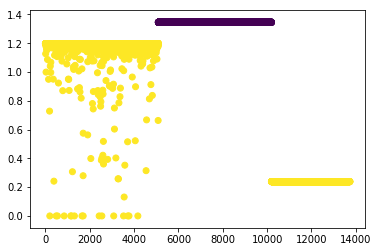

0.12282280261157903


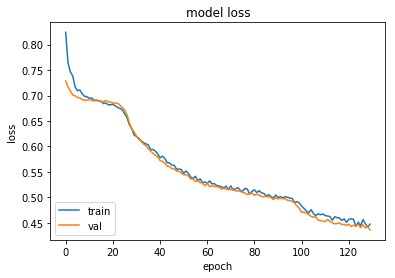

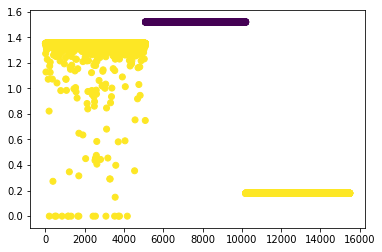

0.14266929093832778


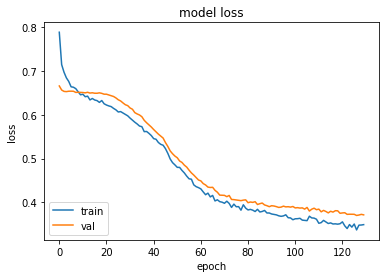

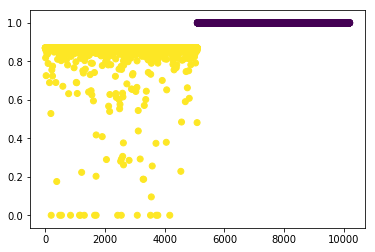

0.14266929093832778


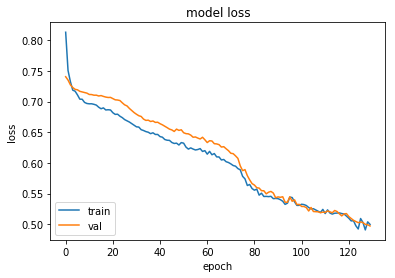

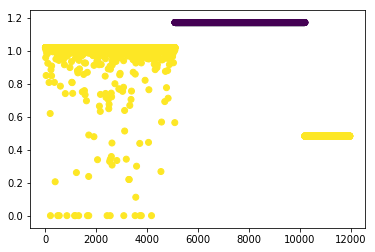

0.14266929093832778


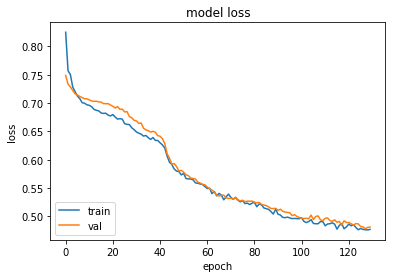

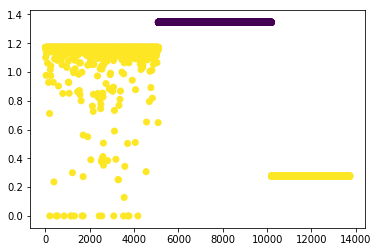

0.14266929093832778


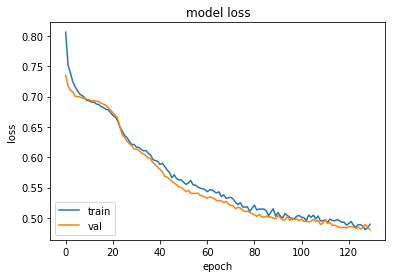

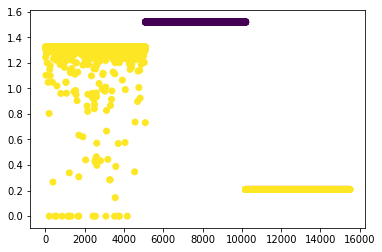

0.16572270086699933


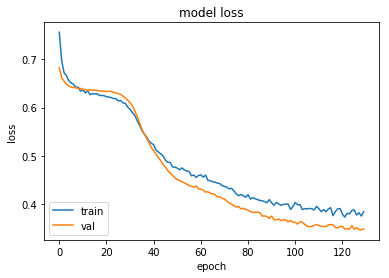

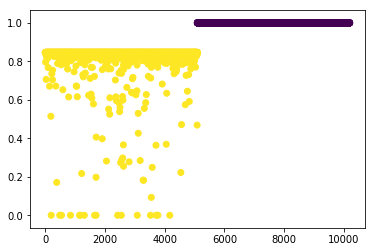

0.16572270086699933


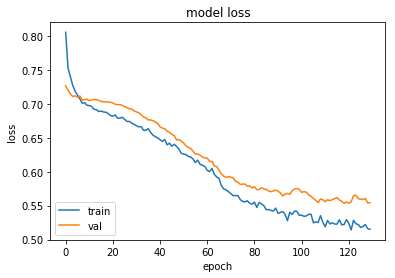

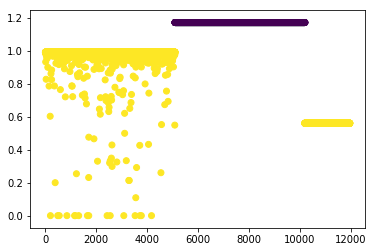

0.16572270086699933


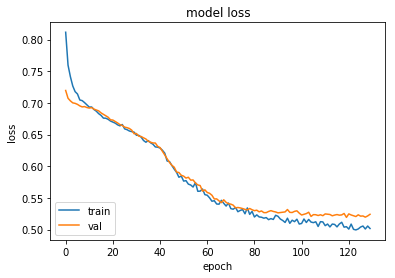

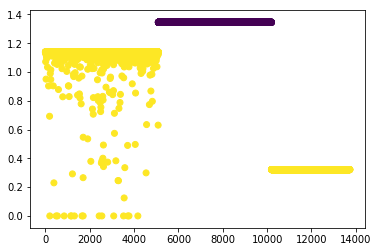

0.16572270086699933


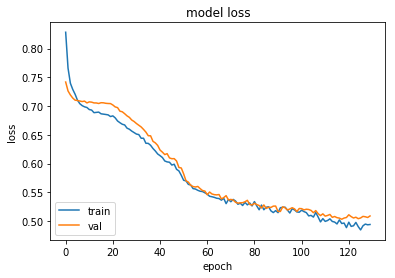

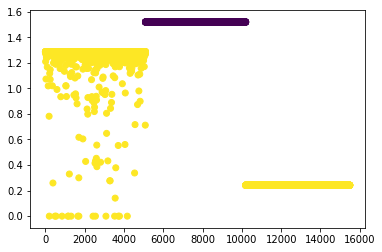

0.192501227152835


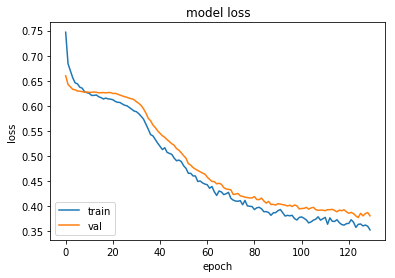

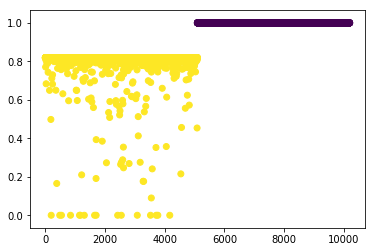

0.192501227152835


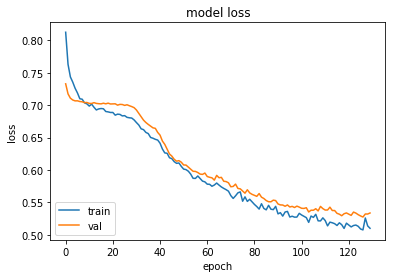

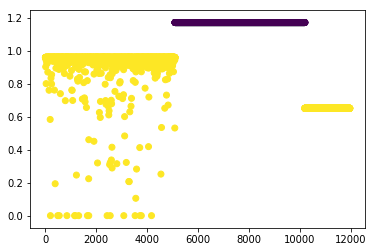

0.192501227152835


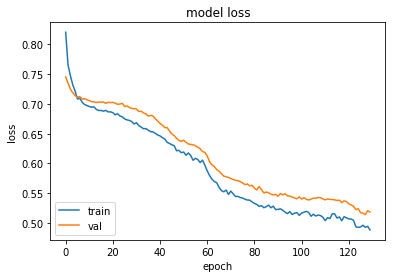

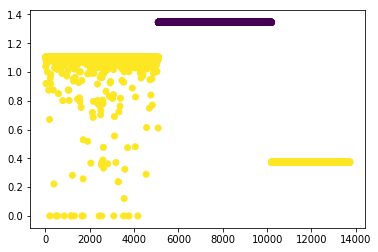

0.192501227152835


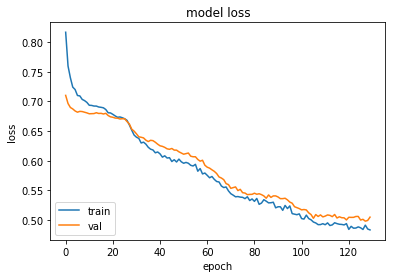

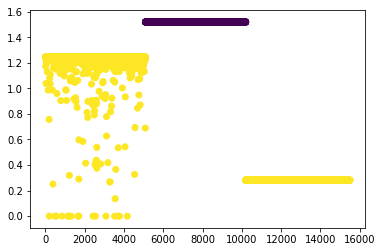

0.223606797749979


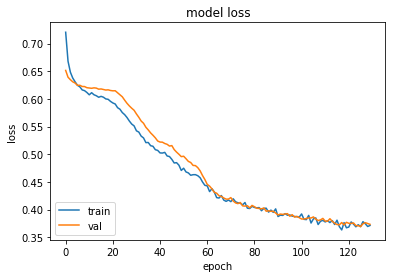

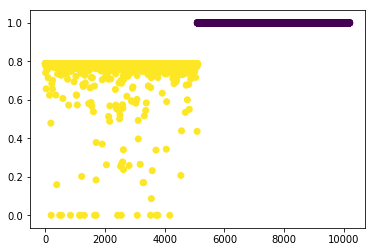

0.223606797749979


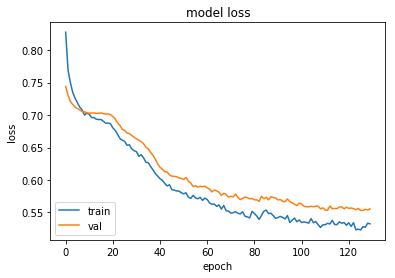

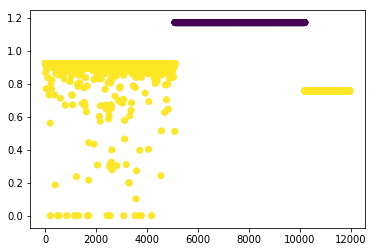

0.223606797749979


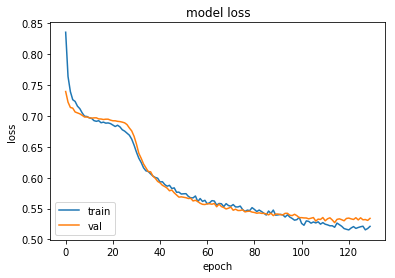

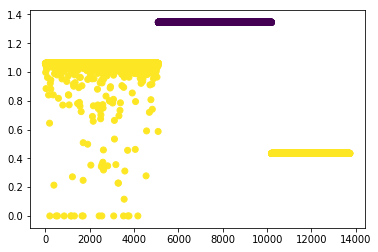

0.223606797749979


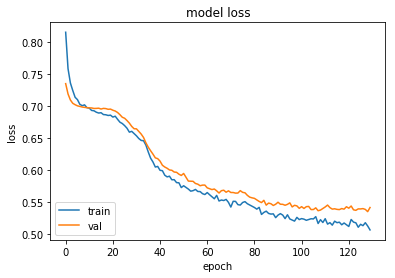

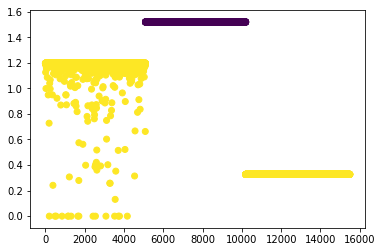

0.25973860395343273


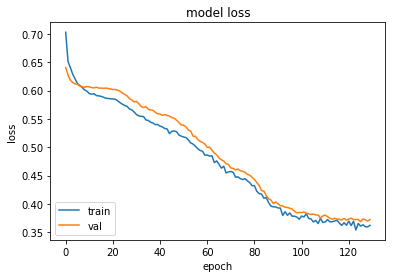

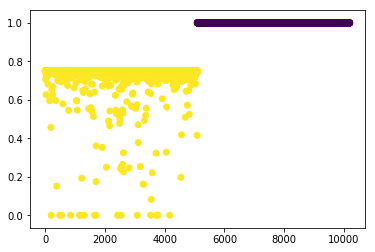

0.25973860395343273


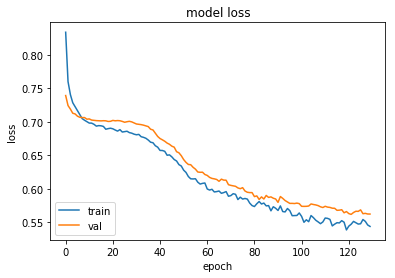

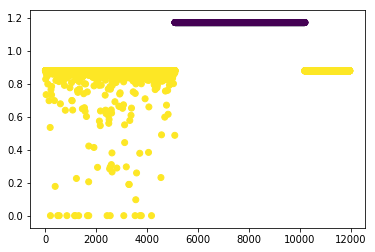

0.25973860395343273


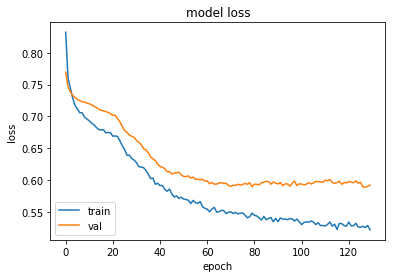

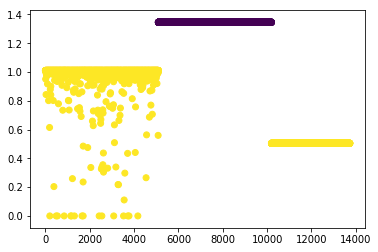

0.25973860395343273


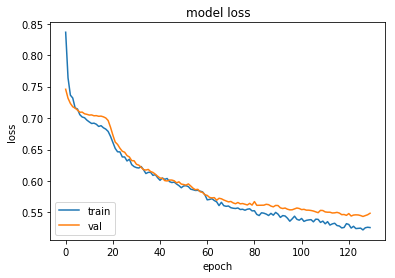

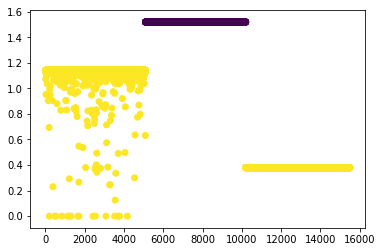

0.30170881682725814


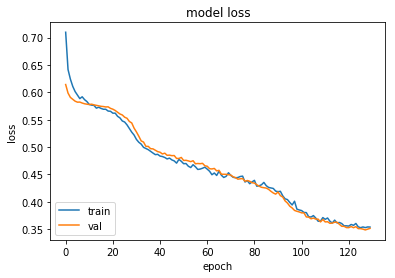

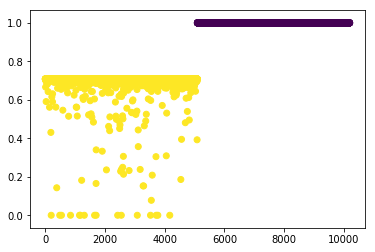

0.30170881682725814


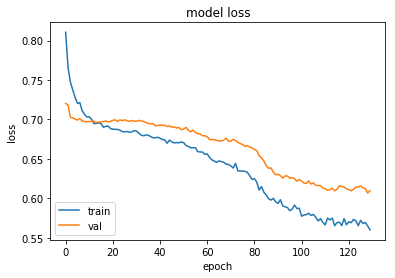

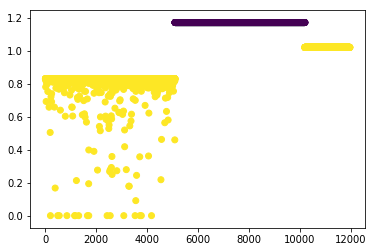

0.30170881682725814


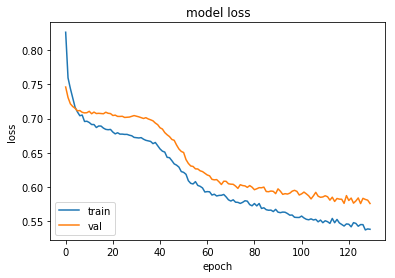

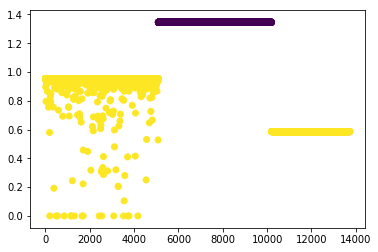

0.30170881682725814


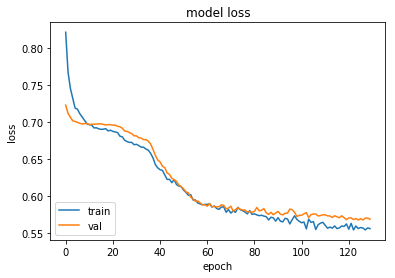

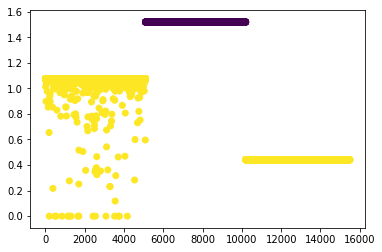

0.3504608431930435


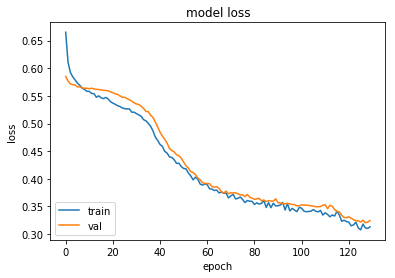

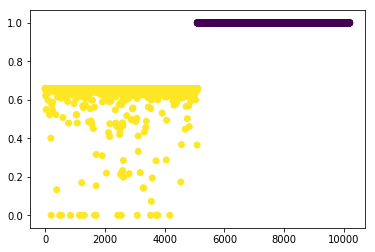

0.3504608431930435


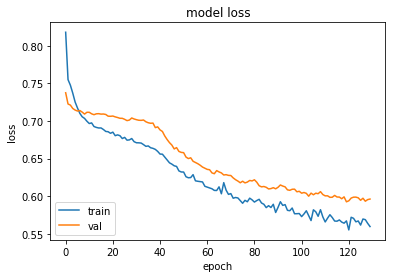

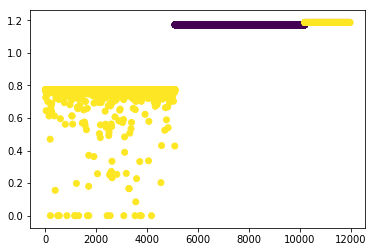

0.3504608431930435


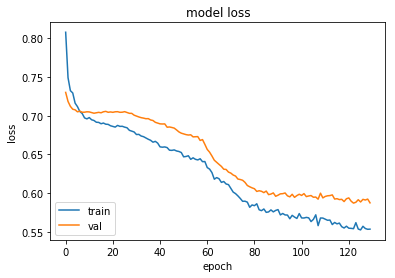

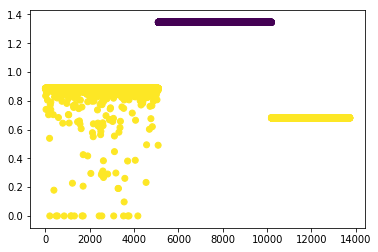

0.3504608431930435


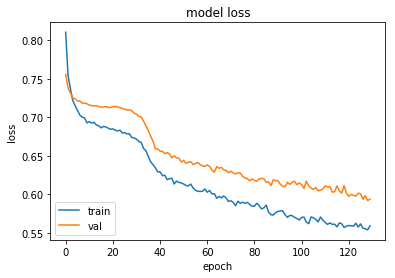

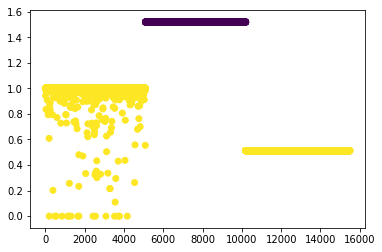

0.4070905315369044


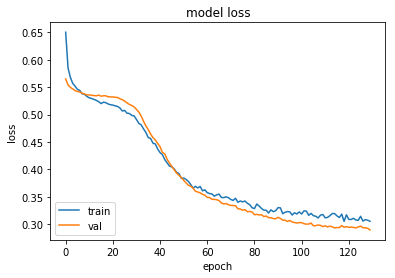

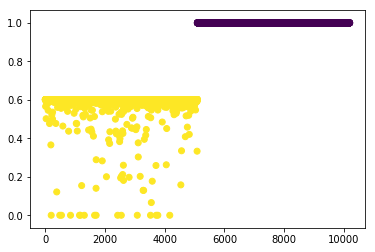

0.4070905315369044


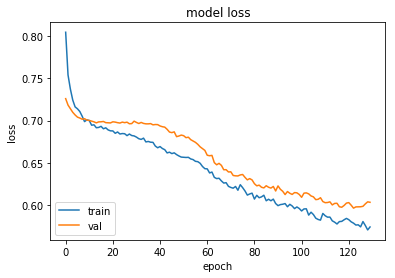

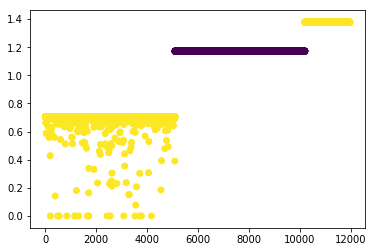

0.4070905315369044


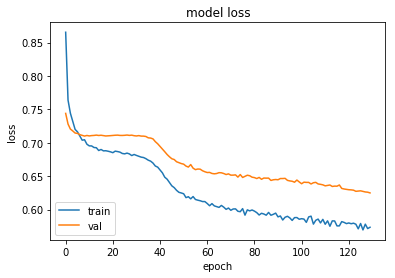

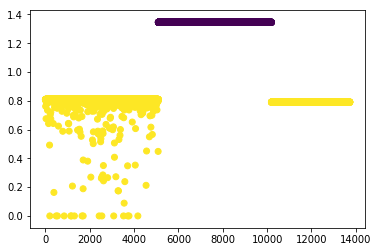

0.4070905315369044


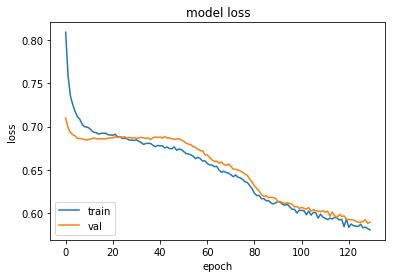

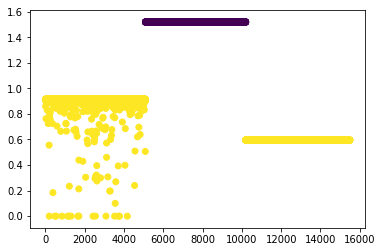

0.4728708045015879


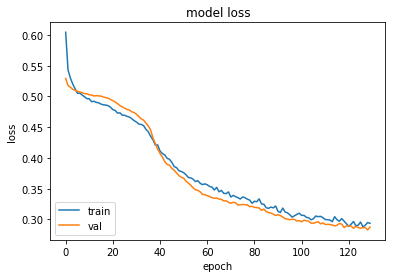

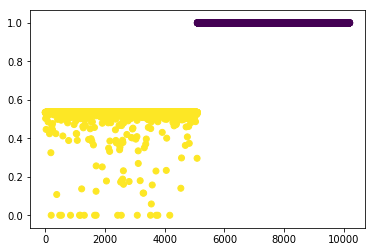

0.4728708045015879


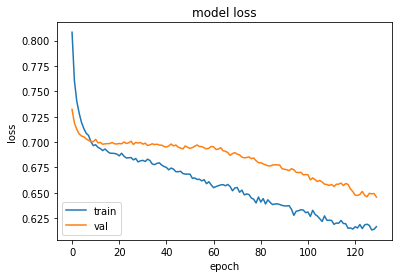

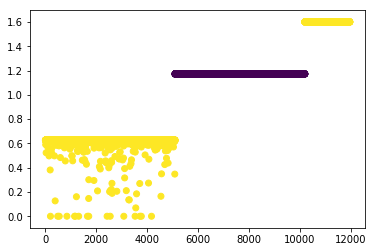

0.4728708045015879


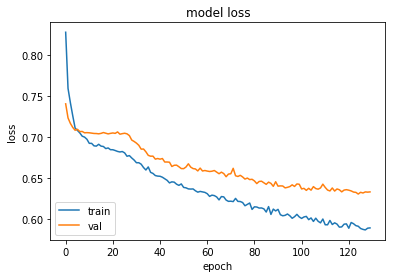

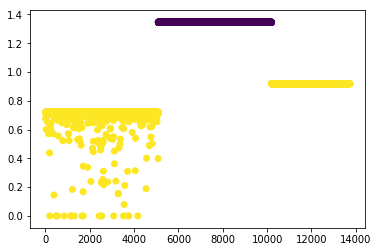

0.4728708045015879


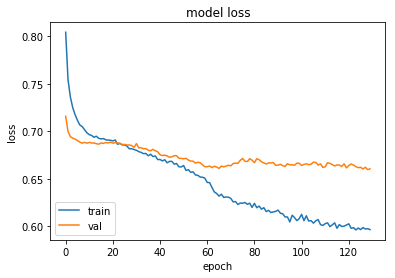

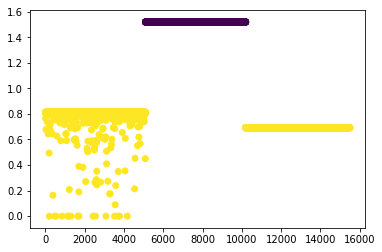

0.5492802716530589


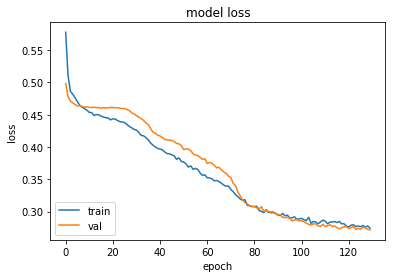

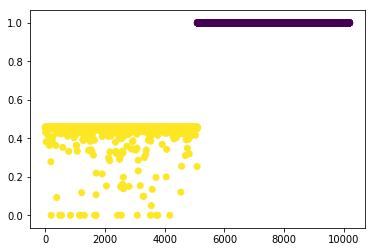

0.5492802716530589


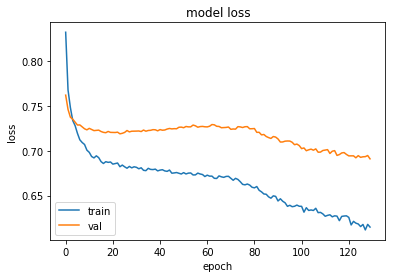

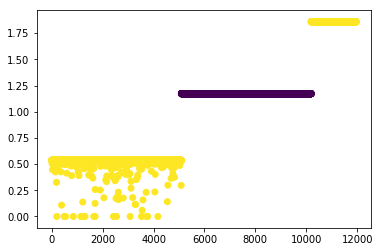

0.5492802716530589


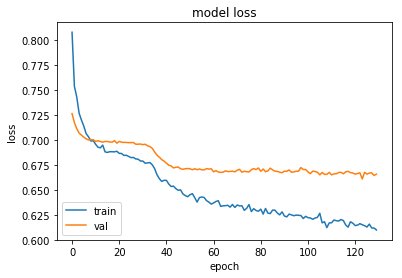

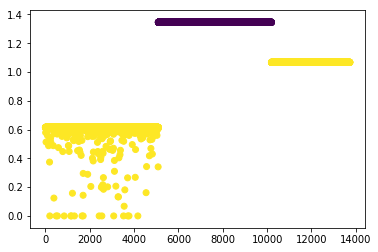

0.5492802716530589


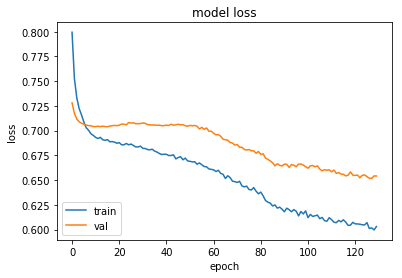

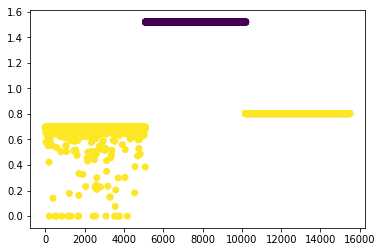

0.6380364656795914


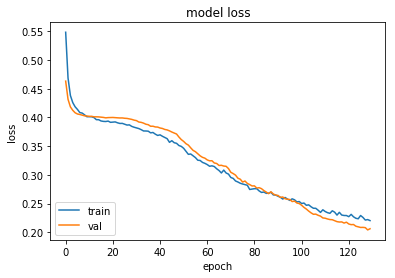

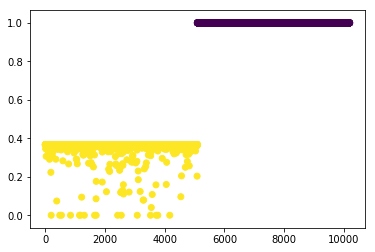

0.6380364656795914


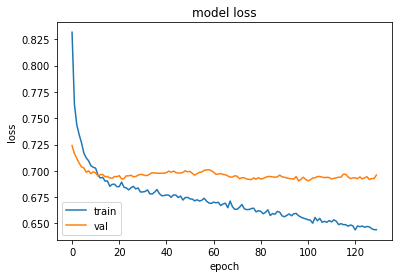

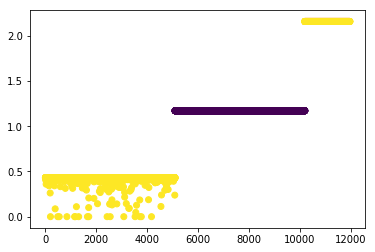

0.6380364656795914


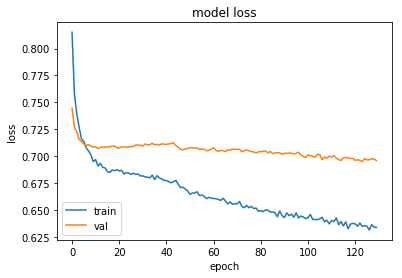

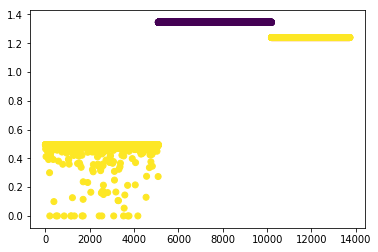

0.6380364656795914


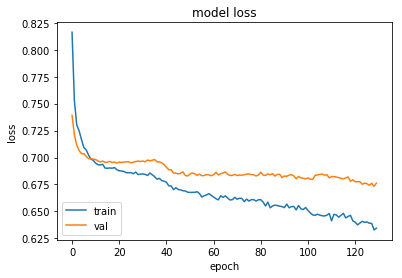

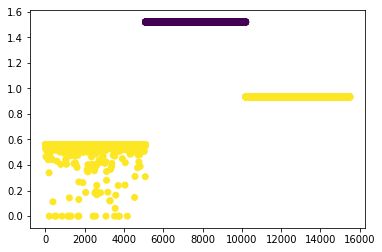

0.7411344491069477


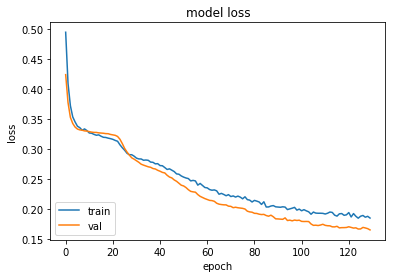

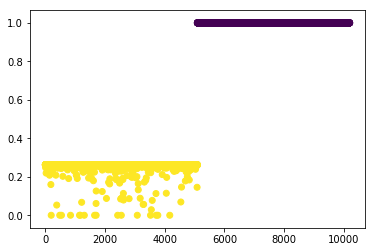

0.7411344491069477


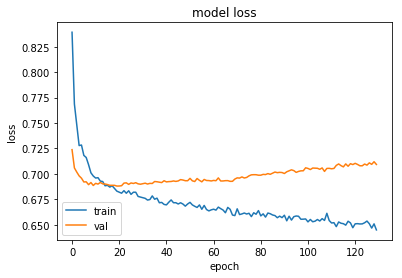

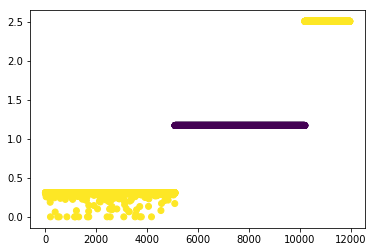

0.7411344491069477


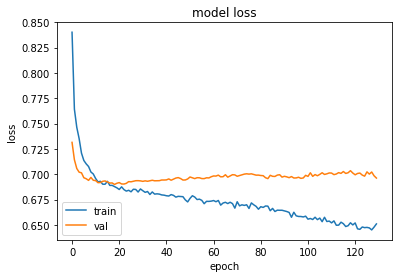

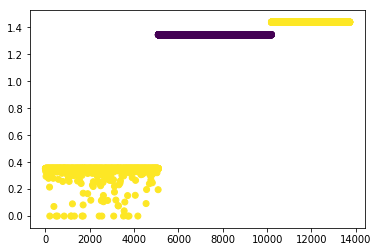

0.7411344491069477


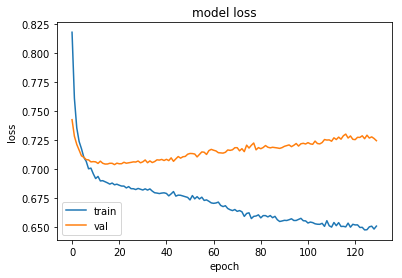

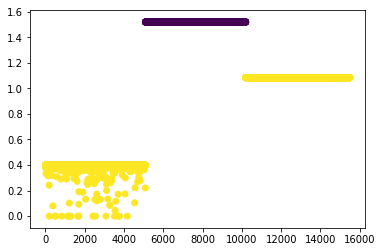

0.8608916593317348


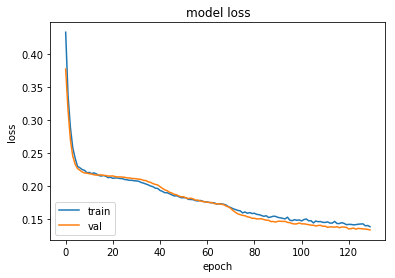

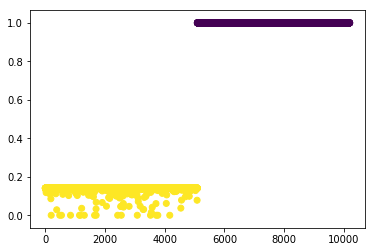

0.8608916593317348


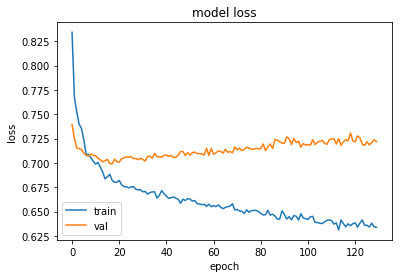

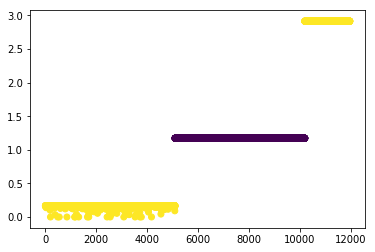

0.8608916593317348


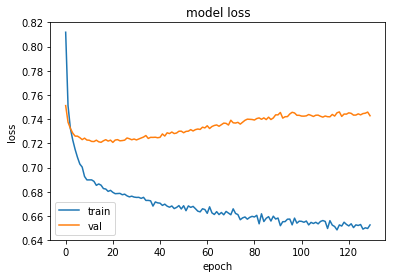

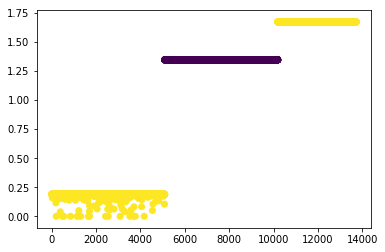

0.8608916593317348


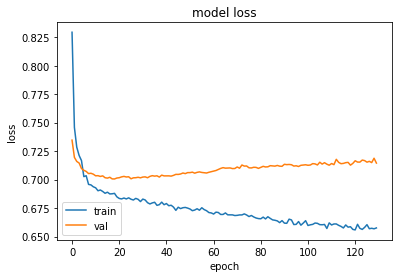

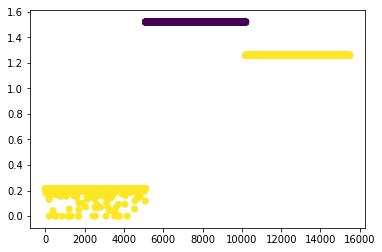

In [44]:
for alpha in alphas:
    for i in range(0,n_splits+1):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i    
        end_ind = int(end_ind)
        cur_X = np.concatenate((X_mix, X_bad[:end_ind]))
        cur_y = np.concatenate((y_mix, np.ones((end_ind,1)))).ravel()
        cur_w = upd_weights(alpha, y_mix, w_g = gen_w_normed, num_true_bad=end_ind).ravel()
        
        idx = np.random.permutation(len(cur_y))    
    
        net = build_net()
        history = net.fit(cur_X[idx], cur_y[idx], 
                          batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w[idx])
        if i%3==0:
            print (alpha)
            history_plot(history)
            
            plt.scatter(np.arange(len(cur_w)), cur_w, c = cur_y)#np.concatenate((y_mix, 2*np.ones((end_ind,1)))).ravel())
            plt.show()

        y_pred=net.predict(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
            ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
            ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]

In [45]:
ours_pr_aucs

{0.05000000000000001: [0.5344086558414157,
  0.5327170239554928,
  0.53412935350297,
  0.5360138122510685,
  0.5356868973998372,
  0.5315106300472575,
  0.5393410182327945,
  0.531863975401395,
  0.532477601389606,
  0.5327956636523998,
  0.5339904625847196],
 0.05807931748207712: [0.5317357569829847,
  0.5345114901178116,
  0.5327601282591001,
  0.5325565014583632,
  0.5356316763663378,
  0.5323814022477449,
  0.5319932745898812,
  0.5354704607839422,
  0.533824517816432,
  0.5339957947307616,
  0.531752050261268],
 0.06746414238367818: [0.5290938064753474,
  0.5348133738997726,
  0.5356500499665771,
  0.5329966346789536,
  0.5350879357709004,
  0.5350103870948852,
  0.5341241517682571,
  0.5329352526375608,
  0.5357048952558053,
  0.5333813095625667,
  0.5319877050820478],
 0.07836542688315398: [0.5378782947652984,
  0.5349049216896138,
  0.5342073685976636,
  0.528531774188209,
  0.5322736906305592,
  0.5328096005578132,
  0.5368355452277256,
  0.5353987864036194,
  0.53038582968375

# Classic methods

## Unsupervised

In [46]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [47]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}

Isolation Forest
('recall_score ', 0.0274442538593482)
('precision_score ', 0.5111821086261981)
('f1_score ', 0.0520918118183298)
confusion_matrix 
[[5017  153]
 [5670  160]]


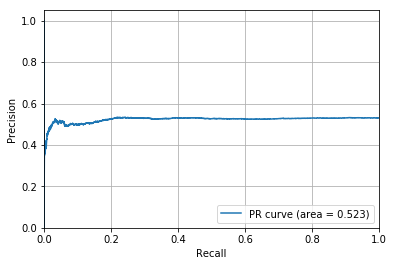

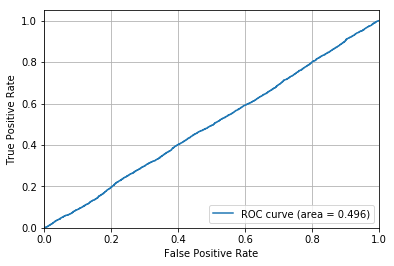

One-Class SVM
('recall_score ', 0.024013722126929673)
('precision_score ', 0.4827586206896552)
('f1_score ', 0.045751633986928095)
confusion_matrix 
[[5020  150]
 [5690  140]]


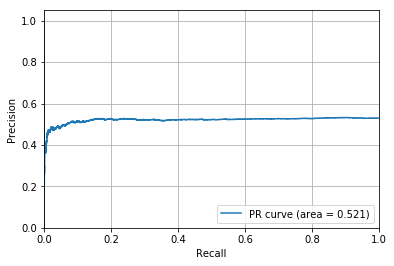

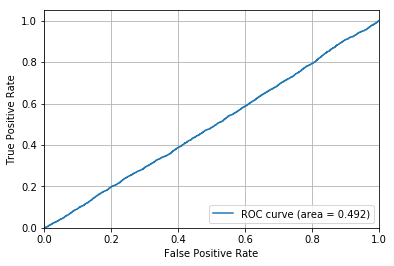

In [48]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


classifiers_classic_uns = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)
}


for i, (clf_name, clf) in enumerate(classifiers_classic_uns.items()):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        


        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=pr_auc      
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=roc_auc
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        



## Supervised

In [50]:
!pip install xgboost

    100% |████████████████████████████████| 481kB 2.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/aryzhikov/.cache/pip/wheels/44/75/71/94198575ab2a2946397287601c0632d196bc56a7ff4b985aba
Successfully built xgboost
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [51]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

In [52]:
classifiers_classic_sup = {
    "XGBClassifier": xgb.XGBClassifier(n_estimators=60, max_depth=10, nthread=-1, seed=111)
}

In [53]:
supervised_pr_aucs = {}
supervised_roc_aucs = {}

In [55]:
for i, (clf_name, clf) in enumerate(classifiers_classic_sup.items()):
    for i in range(1,n_splits+1):
        if step*i>len(X_bad):
            end_ind=len(X_bad)
        else:   
            end_ind=step*i
        end_ind = int(end_ind)
        clf.fit(np.concatenate((X_good, X_bad[:end_ind])), 
                np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()) 
        y_pred = clf.predict_proba(X_test)[:,1]
        if clf_name in supervised_pr_aucs:
            # append the new number to the existing array at this slot
            supervised_pr_aucs[clf_name].append(average_precision_score(y_test, y_pred))
            supervised_roc_aucs[clf_name].append(roc_auc_score(y_test, y_pred))
        else:
            # create a new array in this slot
            supervised_pr_aucs[clf_name] = [average_precision_score(y_test, y_pred)]
            supervised_roc_aucs[clf_name] = [roc_auc_score(y_test, y_pred)]

## All together

In [56]:
supervised_pr_aucs['XGBClassifier'].insert(0, 0.5), supervised_roc_aucs['XGBClassifier'].insert(0, 0.5)
supervised_pr_aucs, supervised_roc_aucs

({'XGBClassifier': [0.5,
   0.5359863418831574,
   0.5344408467600594,
   0.5274134926778578,
   0.5359643865166218,
   0.5280385850917071,
   0.5261516663483055,
   0.5273456563075409,
   0.519899941496205,
   0.5250305462208913,
   0.5300279780806629]},
 {'XGBClassifier': [0.5,
   0.5042631987551881,
   0.5049217679514019,
   0.49882094548639566,
   0.5028862748871142,
   0.5004507466548997,
   0.49851984499570356,
   0.4963787983849296,
   0.4895913885027421,
   0.4923567653469847,
   0.49963053770433064]})

In [57]:
unsupervised_roc_aucs['Isolation Forest'] = np.ones((11))*unsupervised_roc_aucs['Isolation Forest']
unsupervised_pr_aucs['Isolation Forest'] = np.ones((11))*unsupervised_pr_aucs['Isolation Forest']
unsupervised_roc_aucs['One-Class SVM'] = np.ones((11))*unsupervised_roc_aucs['One-Class SVM']
unsupervised_pr_aucs['One-Class SVM'] = np.ones((11))*unsupervised_pr_aucs['One-Class SVM']

unsupervised_pr_aucs, unsupervised_roc_aucs 

({'Isolation Forest': array([0.52291947, 0.52291947, 0.52291947, 0.52291947, 0.52291947,
         0.52291947, 0.52291947, 0.52291947, 0.52291947, 0.52291947,
         0.52291947]),
  'One-Class SVM': array([0.52066526, 0.52066526, 0.52066526, 0.52066526, 0.52066526,
         0.52066526, 0.52066526, 0.52066526, 0.52066526, 0.52066526,
         0.52066526])},
 {'Isolation Forest': array([0.49580145, 0.49580145, 0.49580145, 0.49580145, 0.49580145,
         0.49580145, 0.49580145, 0.49580145, 0.49580145, 0.49580145,
         0.49580145]),
  'One-Class SVM': array([0.49245811, 0.49245811, 0.49245811, 0.49245811, 0.49245811,
         0.49245811, 0.49245811, 0.49245811, 0.49245811, 0.49245811,
         0.49245811])})

In [58]:
ours_pr_aucs

{0.05000000000000001: [0.5344086558414157,
  0.5327170239554928,
  0.53412935350297,
  0.5360138122510685,
  0.5356868973998372,
  0.5315106300472575,
  0.5393410182327945,
  0.531863975401395,
  0.532477601389606,
  0.5327956636523998,
  0.5339904625847196],
 0.05807931748207712: [0.5317357569829847,
  0.5345114901178116,
  0.5327601282591001,
  0.5325565014583632,
  0.5356316763663378,
  0.5323814022477449,
  0.5319932745898812,
  0.5354704607839422,
  0.533824517816432,
  0.5339957947307616,
  0.531752050261268],
 0.06746414238367818: [0.5290938064753474,
  0.5348133738997726,
  0.5356500499665771,
  0.5329966346789536,
  0.5350879357709004,
  0.5350103870948852,
  0.5341241517682571,
  0.5329352526375608,
  0.5357048952558053,
  0.5333813095625667,
  0.5319877050820478],
 0.07836542688315398: [0.5378782947652984,
  0.5349049216896138,
  0.5342073685976636,
  0.528531774188209,
  0.5322736906305592,
  0.5328096005578132,
  0.5368355452277256,
  0.5353987864036194,
  0.53038582968375

In [59]:
ours_pr_aucs['ours with alpha=0.'] = np.ones((11))*ours_pr_aucs['ours with alpha=0.']
ours_roc_aucs['ours with alpha=0.'] = np.ones((11))*ours_roc_aucs['ours with alpha=0.']

In [60]:
ours_pr_aucs[1.0].insert(0, 0.5)
ours_roc_aucs[1.0].insert(0, 0.5)

In [61]:
#ours_pr_aucs, ours_roc_aucs 

In [68]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [69]:
pr_s = {k: v for d in (unsupervised_pr_aucs, ours_pr_aucs, supervised_pr_aucs) for k, v in d.items()}
roc_s = {k: v for d in (unsupervised_roc_aucs, ours_roc_aucs, supervised_roc_aucs) for k, v in d.items()}

In [70]:
roc_s

{0.05000000000000001: [0.5043636429990943,
  0.5072038843970526,
  0.5090237250797084,
  0.5099550779500417,
  0.5094837116097289,
  0.5039352910145947,
  0.5122305921150854,
  0.5052605910202348,
  0.503706633135486,
  0.5028614416859372,
  0.5050196077780837],
 0.05807931748207712: [0.5037311179751236,
  0.5079140442784105,
  0.5068650115622855,
  0.5094577006147751,
  0.5122459863774049,
  0.5057964540113002,
  0.50630706908507,
  0.5076412108383569,
  0.5075304484574219,
  0.5128943369684583,
  0.5069666833659024],
 0.06746414238367818: [0.5030332834568081,
  0.5073939404998491,
  0.5129608076679351,
  0.5025842951982509,
  0.5112710717259821,
  0.5086750815331889,
  0.5046153093284586,
  0.5056695840563218,
  0.511454127420698,
  0.5078104979579379,
  0.505848326703405],
 0.07836542688315398: [0.5130628444217364,
  0.5057373652587331,
  0.5067977943737952,
  0.49868923164715284,
  0.5044816380291363,
  0.5071804778193231,
  0.5082326955552385,
  0.5115900215984155,
  0.50624084721

In [76]:
def plot_for_comparison(dic, names, ylabel="PR AUC", y_lim=(0.3,1.0)):
    plt.figure(figsize=(9,9))
    for i, name in enumerate(names):
        plt.plot(np.arange(0, 1.1, 0.1), dic[name], label=name)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0,1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [82]:
all_methods

['Isolation Forest',
 'One-Class SVM',
 1,
 0.14266929093832778,
 0.05807931748207712,
 0.223606797749979,
 0.16572270086699933,
 'ours with alpha=0.',
 0.4728708045015879,
 0.09102821015130401,
 0.25973860395343273,
 0.12282280261157903,
 0.3504608431930435,
 0.07836542688315398,
 0.4070905315369044,
 0.6380364656795914,
 0.192501227152835,
 0.7411344491069477,
 0.5492802716530589,
 0.05000000000000001,
 0.10573712634405641,
 0.06746414238367818,
 0.8608916593317348,
 0.30170881682725814,
 'XGBClassifier']

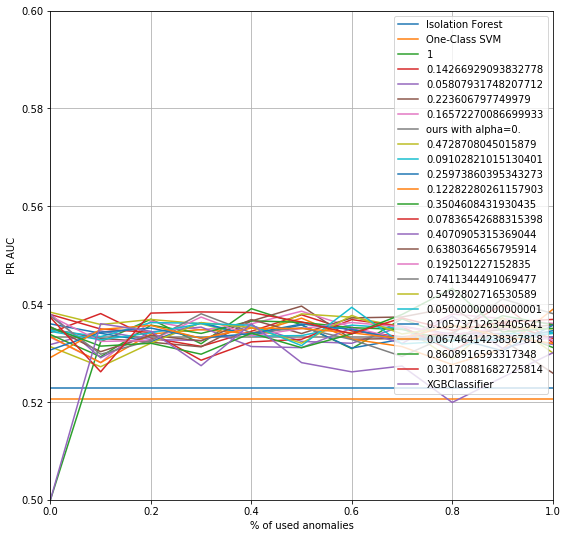

In [78]:
plot_for_comparison(pr_s, all_methods, ylabel="PR AUC",y_lim=(0.5,0.6))

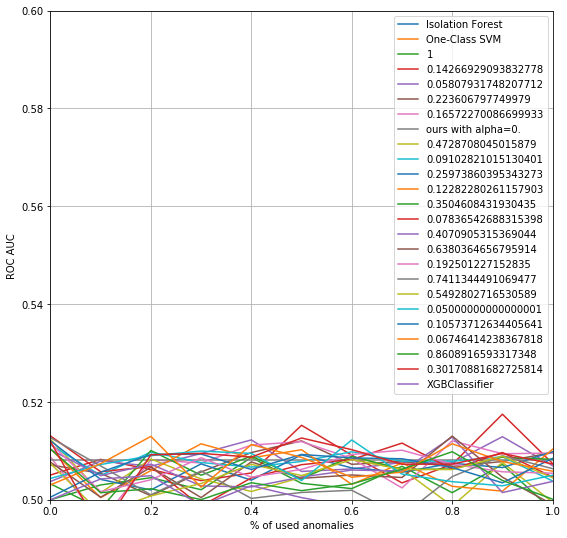

In [81]:
plot_for_comparison(roc_s, all_methods, ylabel="ROC AUC", y_lim=(0.5,0.6))